In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from tqdm.auto import tqdm
from multiprocessing import Pool
from recombinator.iid_bootstrap import iid_bootstrap
import recombinator.block_bootstrap as bb
from numba import jit
from functools import partial

sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1.7)

# Main

## Get return data

In [3]:
returns_df = pd.read_json('https://retirementplans.vanguard.com/web/angular/app/nesteggcalculator/data/config.json')
returns_df = returns_df['data'].apply(pd.Series)
returns_df['year'] = returns_df['year'].astype(int)

returns_df.head()

,year,stocks,bonds,cash,cpi
0,1926,0.1163,0.0738,0.032,-0.0112
1,1927,0.3744,0.0743,0.031,-0.0226
2,1928,0.4360,0.0284,0.040,-0.0116
3,1929,-0.0855,0.0328,0.044,0.0058
4,1930,-0.2478,0.0796,0.022,-0.0640


## Simulation

In [4]:
class PortfolioSim:
    def __init__(self, returns_df, savings_years,
        initial_balance, yearly_spending, portfolio_allocation):
        """
        returns_df:           the dataframe of returns from the VG site
        savings_years:        the max number of years to run the simulation
        initial_balance:      initial cash
        yearly_spending:      dollars spent each year (real)
        portfolio allocation: numpy array giving weights 
                              for [stocks,bonds,cash] (should sum to 1)
        """
        
        self.returns_df = returns_df
        self.savings_years = savings_years
        self.initial_balance = initial_balance
        self.yearly_spending = yearly_spending
        self.portfolio_allocation = portfolio_allocation

    def gen_bootstrap_samples(self, bootstrap_replications, kind, block_length=5):
        # Generate bootstrap samples

        if kind == "iid":
            bootstrap_samples = iid_bootstrap(
                np.array(self.returns_df),
                replications=bootstrap_replications,
                sub_sample_length=self.savings_years,
            )
        elif kind == "stationary":
            bootstrap_samples = bb.stationary_bootstrap(
                np.array(self.returns_df),
                block_length=block_length,
                replications=bootstrap_replications,
                sub_sample_length=self.savings_years,
            )
        else: 
            raise Exception(f'Unknown bootstrap type: {kind}')

        self.bootstrap_samples = bootstrap_samples

    @staticmethod
    @jit(nopython=True)
    def sim_portfolio(
        bootstrap_sample,
        savings_years,
        initial_balance,
        yearly_spending,
        portfolio_allocation,
    ):

        # Adjust spending for inflation (same way as VG code)
        yearly_spending_adj = np.cumprod(1 + bootstrap_sample[:, -1]) * yearly_spending

        # Portfolio return
        yearly_portfolio_return = (
            np.ascontiguousarray(bootstrap_sample[:, 1:4]) @ portfolio_allocation
        )

        # Simulation
        running_balance = initial_balance
        yearly_balance = np.empty(savings_years)

        for t in range(0, savings_years):

            running_balance = (running_balance - yearly_spending_adj[t]) * (
                1 + yearly_portfolio_return[t]
            )
            yearly_balance[t] = running_balance

            if running_balance < 0:
                yearly_balance[t:] = 0
                break

        return yearly_balance

    def run_simulation(self):

        # Output list
        yearly_balance_list = []

        # Partial function for parallel map
        run_trial = partial(
            self.sim_portfolio,
            savings_years=self.savings_years,
            initial_balance=self.initial_balance,
            yearly_spending=self.yearly_spending,
            portfolio_allocation=self.portfolio_allocation,
        )

        with Pool(8) as p:
            for yearly_balance in tqdm(
                p.imap_unordered(run_trial, self.bootstrap_samples, chunksize=5000),
                total=len(self.bootstrap_samples),
            ):

                # Save balance paths
                yearly_balance_list.append(yearly_balance)

        self.yearly_balance_list = yearly_balance_list
                
        return yearly_balance_list
    
    @staticmethod
    @jit(nopython=True)
    def get_prob_not_broke(years, yearly_balance_list):

        n = len(yearly_balance_list)
        went_broke_list = np.empty(n)

        for i in range(n):
            went_broke = int(np.any(yearly_balance_list[i][:years]<=0))
            went_broke_list[i] = went_broke

        return 1 - np.mean(went_broke_list) 
    
    def get_survival_df(self):
        
        yearly_balance_list = self.yearly_balance_list
        savings_years = self.savings_years
        
        # Probability of not going broke after t years
        t_range = list(range(0,savings_years))
        prob_not_broke = []

        # Partial function for map
        partial_f = partial(
            self.get_prob_not_broke,
            yearly_balance_list=np.array(yearly_balance_list),
        )
        
        for result in tqdm(
            map(partial_f, list(np.array(t_range)+1)), 
            total = len(t_range)):
            prob_not_broke.append(result)
            
        # Save the above results as dataframe
        prob_results_df = pd.DataFrame(
            [(np.array(t_range) + 1), prob_not_broke], index=["year", "prob_not_broke"]
        ).T
        
        return prob_results_df

### Params

In [5]:
savings_years = 50
initial_balance = 1e6
yearly_spending = 75e3

portfolio_allocation = np.array([.50, .30, .20])

### IID Bootstrap

In [6]:
sim_iid = PortfolioSim(returns_df, savings_years, initial_balance, 
                       yearly_spending, portfolio_allocation)

print('Generating bootstrap sample...')
sim_iid.gen_bootstrap_samples(100000, kind = 'iid')

print('Running simulations...')
yearly_balance_list = sim_iid.run_simulation()

print('Get survival rate...')
iid_survival_df = sim_iid.get_survival_df().rename(columns = {'prob_not_broke': 'prob_not_broke_iid'})

Generating bootstrap sample...


  0%|          | 0/100000 [00:00<?, ?it/s]

Running simulations...


  0%|          | 0/50 [00:00<?, ?it/s]

Get survival rate...


100%|██████████| 50/50 [00:01<00:00, 40.81it/s]


In [7]:
print(f"Probability your savings last 30 years: \
      {iid_survival_df.set_index('year').loc[30, 'prob_not_broke_iid']:.2%}")

print(f"Probability your savings last {savings_years} years: \
      {iid_survival_df.set_index('year').loc[50, 'prob_not_broke_iid']:.2%}")

Probability your savings last 30 years:       19.43%
Probability your savings last 50 years:       7.78%


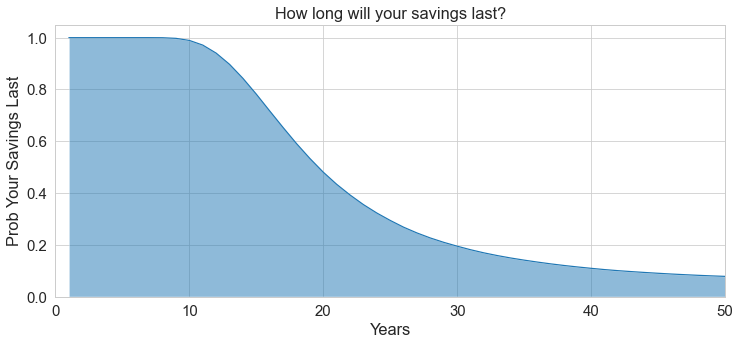

In [8]:
## How long will your savings last?
# Should replicate VG app results

fig, ax = plt.subplots(figsize = (12,5))

plt.plot(iid_survival_df['year'], iid_survival_df['prob_not_broke_iid'])
plt.fill_between(iid_survival_df['year'], 0, iid_survival_df['prob_not_broke_iid'], alpha = 0.5)
plt.ylim(0,1.05)
plt.xlim(0,savings_years)
plt.xlabel('Years')
plt.ylabel('Prob Your Savings Last');
plt.title('How long will your savings last?');

### Stationary Bootstrap

In [9]:
sim_st = PortfolioSim(returns_df, savings_years, initial_balance, 
                       yearly_spending, portfolio_allocation)

print('Generating bootstrap sample...')
sim_st.gen_bootstrap_samples(100000, kind = 'stationary', block_length = 10)

print('Running simulations...')
yearly_balance_list = sim_st.run_simulation()

print('Get survival rate...')
st_survival_df = sim_st.get_survival_df().rename(columns = {'prob_not_broke': 'prob_not_broke_st'})

Generating bootstrap sample...


  0%|          | 0/100000 [00:00<?, ?it/s]

Running simulations...


 38%|███▊      | 19/50 [00:00<00:00, 90.87it/s]

Get survival rate...


100%|██████████| 50/50 [00:00<00:00, 80.72it/s]


In [10]:
# Merge survival rates for both IID and Stationary bootstraps
survival_df = iid_survival_df.merge(st_survival_df, on = 'year')

### Compare

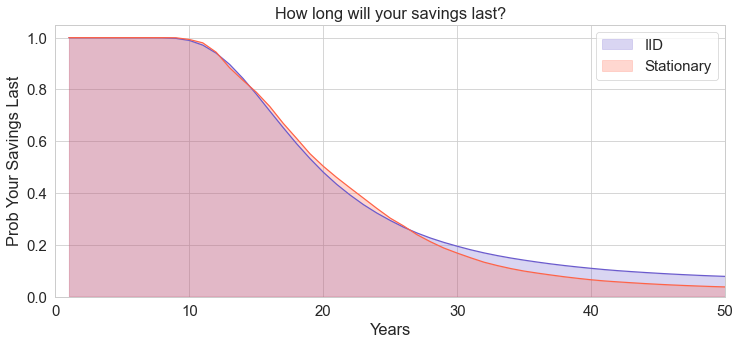

In [11]:
## How long will your savings last?

fig, ax = plt.subplots(figsize=(12, 5))

plt.plot(survival_df["year"], survival_df["prob_not_broke_iid"], color="slateblue")
plt.fill_between(
    survival_df["year"],
    0,
    survival_df["prob_not_broke_iid"],
    alpha=0.25,
    label="IID",
    color="slateblue",
)
plt.plot(survival_df["year"], survival_df["prob_not_broke_st"], color="tomato")
plt.fill_between(
    survival_df["year"],
    0,
    survival_df["prob_not_broke_st"],
    alpha=0.25,
    label="Stationary",
    color="tomato",
)
plt.ylim(0, 1.05)
plt.xlim(0, savings_years)
plt.xlabel("Years")
plt.ylabel("Prob Your Savings Last")
plt.legend()
plt.title("How long will your savings last?");

# Etcetera

In [20]:
import statsmodels.tsa.arima_process

In [21]:
y = statsmodels.tsa.arima_process.arma_generate_sample([1, -0.5], [1, 0.1], nsample = 1000, burnin=50)
y_bs_iid = iid_bootstrap(y, replications = 1)[0]
y_bs_st = bb.stationary_bootstrap(y, replications = 1, block_length = 10)[0]

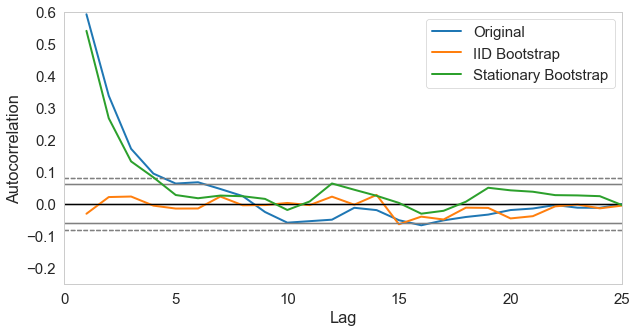

In [22]:
plt.figure(figsize = (10,5))

pd.plotting.autocorrelation_plot(y, label = 'Original', lw = 2)
pd.plotting.autocorrelation_plot(y_bs_iid, label = 'IID Bootstrap', lw = 2)
pd.plotting.autocorrelation_plot(y_bs_st, label = 'Stationary Bootstrap', lw = 2)
plt.legend()
plt.xlim(0, 25)
plt.ylim(-0.25, 0.6);

In [31]:
from recombinator.optimal_block_length import optimal_block_length
b_star = optimal_block_length(np.array(returns_df))
print(b_star)

(OptimalBlockLength(b_star_sb=14.493222185931998, b_star_cb=16.59059785672629), OptimalBlockLength(b_star_sb=1.1053824105526038, b_star_cb=1.2653469888274997), OptimalBlockLength(b_star_sb=1.9286234477249318, b_star_cb=2.207722729133041), OptimalBlockLength(b_star_sb=13.056544354781558, b_star_cb=14.946012281447752), OptimalBlockLength(b_star_sb=8.97158123067897, b_star_cb=10.269896812982365))
